Description:  This script produces Figure 7 (equivalent reflectivity factor contours for Edmond-Carney storm at surface and mid-levels)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyart
import xarray as xr
import glob,sys,os
import pandas as pd
from operator import itemgetter
from copy import deepcopy
from datetime import datetime
import scipy.ndimage as ndimage
from wsr88d_parsing import plot_point


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
files_radar = sorted(glob.glob(os.path.expanduser('/path/to/KTLX/files')))

files_rad_interest = list(itemgetter(
    6, 7, 8, 9, 10, 11, 17, 18, 19, 26, 27, 30)(files_radar))

In [72]:
plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.markerscale'] = 2
plt.rcParams["font.size"] = 13

In [83]:
# List of all elevation angles (sweep angles) that have a visible WER/BWER in PPI plot
# This list will be used while iterating through radar files

mdlvl_swps = [11,11,12,12,12,13,12,12,12,10,10,10]
mdlvl_swps = np.reshape(mdlvl_swps,(4,3))

In [6]:
all_radars = []

for i in range(len(files_rad_interest)):
    
    radar = pyart.io.read(files_rad_interest[i])
    filter = pyart.filters.GateFilter(radar)
    filter.exclude_below('reflectivity', 20)
    filter = pyart.correct.despeckle_field(radar, 'reflectivity', size=30, gatefilter=filter)
    corrected_reflectivity = deepcopy(radar.fields['reflectivity'])
    corrected_reflectivity['data'] = np.ma.masked_where(filter.gate_excluded, corrected_reflectivity['data'])
    radar.add_field('corrected_reflectivity', corrected_reflectivity, replace_existing=True)

    all_radars.append(radar)

/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


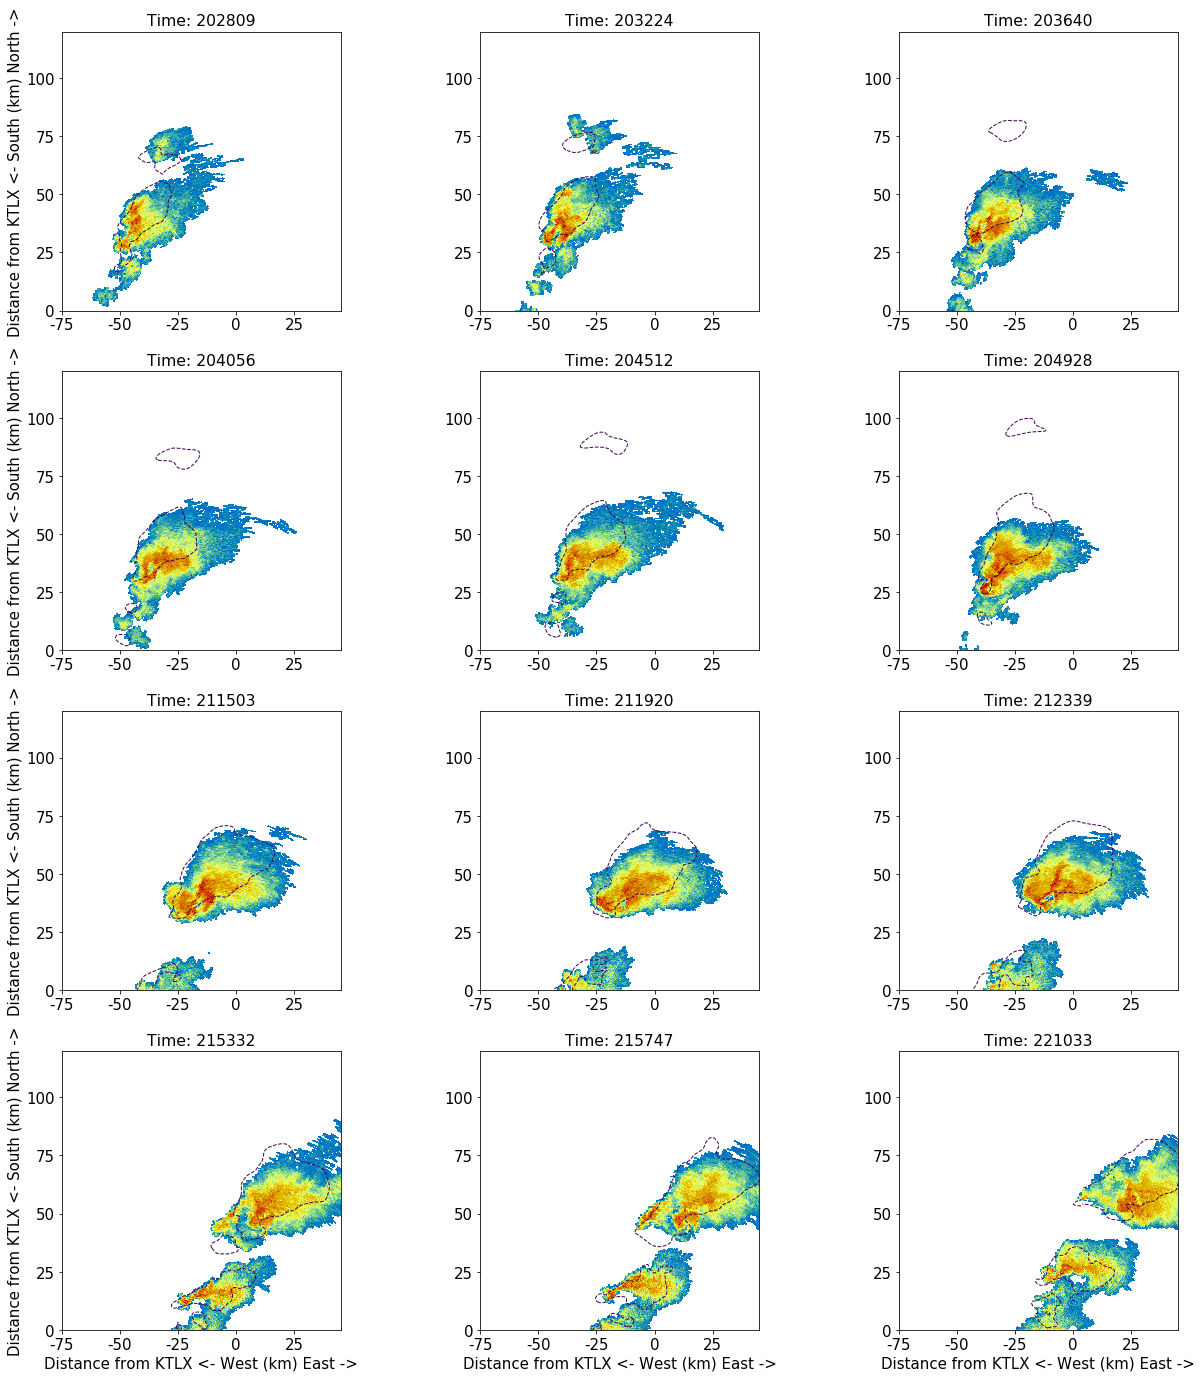

In [85]:
import matplotlib.gridspec as gridspec

all_radars_new = np.reshape(all_radars,(4,3))
llvl_swp = 0
widths = [10, 10, 10]
heights = [10, 10, 10,10]

fig = plt.figure(constrained_layout=False,figsize=(20,25))
spec2 = gridspec.GridSpec(ncols=3, nrows=4, figure=fig,width_ratios=widths,
                          height_ratios=heights)
spec2.update(wspace=0.5, hspace=0)



for row in range(4):
    for col in range(3):
        ax = fig.add_subplot(spec2[row, col])
        display = pyart.graph.RadarDisplay(all_radars_new[row,col])
        display.plot_ppi('corrected_reflectivity',mdlvl_swps[row,col],vmin=20,vmax=70,cmap='pyart_HomeyerRainbow',title_flag=False,colorbar_flag=False,
                     colorbar_orient='horizontal',axislabels_flag=False)
    
        llvl_data = all_radars_new[row,col].get_field(llvl_swp, 'corrected_reflectivity')
        x, y, z = all_radars_new[row,col].get_gate_x_y_z(llvl_swp, edges=False)
        
        x /= 1000.0
        y /= 1000.0
        z /= 1000.0
        
        # apply a gaussian blur to the data set for nice smooth lines:
        # sigma adjusts the distance effect of blending each cell,
        # 4 is arbirarly set for visual impact.
        smooth_data = ndimage.gaussian_filter(llvl_data, sigma=4)
        
        # add contours
        levels = [30]
        
        # adds contours to plot
        contours = ax.contour(x, y, smooth_data, levels, linewidths=1,
                          antialiased=True,linestyles='--')
        
        ratio = 1
        xleft, xright = ax.get_xlim()
        ybottom, ytop = ax.get_ylim()
        # the abs method is used to make sure that all numbers are positive
        # because x and y axis of an axes maybe inversed.
        ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

        ax.set_xlim(-75,45)
        ax.set_xticks([-75,-50,-25,0,25])
        ax.set_xticklabels(['-75','-50','-25','0','25'])
        
        ax.set_ylim(0,120)
        ax.set_yticks([0,25,50,75,100])
        ax.set_yticklabels(['0','25','50','75','100'])
        
        title = datetime.strftime(datetime.strptime(all_radars_new[row,col].time['units'].split('/')[-1].split('.')[0].split(' ')[-1],'%Y-%m-%dT%H:%M:%SZ'),'%H%M%S')
        ax.set_title(f'Time: {title}')
        
        if col == 0:            
            ax.set_ylabel('Distance from KTLX <- South (km) North ->')
        if row == 3:
            ax.set_xlabel('Distance from KTLX <- West (km) East ->')

plt.tight_layout()